In [77]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction import DictVectorizer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split
from ggplot import *
import matplotlib.pyplot as plt

%matplotlib inline

datetime - hourly date + timestamp  

season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 

2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 

3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 

4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

In [4]:
PATH= './'

# Loading training data
x_train= pandas.read_csv(PATH+'train.csv', header=0)  

# Loading test data
x_test = pandas.read_csv(PATH+'test.csv', header=0)


In [5]:
# Isolate target variables in stand-alone vectores
y = x_train["count"]
registered = x_train["registered"]
casual = x_train["casual"]

# Evict the target variables from the explicative matrix
x_train = x_train.drop(["count","casual","registered"],axis=1)

In [6]:
x_train["datetime"] = pandas.to_datetime(x_train["datetime"])

In [7]:
x_test["datetime"] = pandas.to_datetime(x_test["datetime"])

### Days and hours extraction

In [8]:
x_train["hour"] = x_train["datetime"].dt.hour
x_train["day"] =  x_train["datetime"].dt.day
x_train["month"] =  x_train["datetime"].dt.month
x_train["year"] =  x_train["datetime"].dt.year

In [9]:
x_test["hour"] = x_test["datetime"].dt.hour
x_test["day"] =  x_test["datetime"].dt.day
x_test["month"] =  x_test["datetime"].dt.month
x_test["year"] =  x_test["datetime"].dt.year

In [10]:
x_train.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month,year
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,-0.006546,0.001729,0.971524,-0.004797
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,-0.000354,-0.015877,0.001731,0.012021
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,0.002780,0.009829,-0.003394,-0.002482
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.022740,-0.007890,0.012144,-0.012548
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.145430,0.015551,0.257589,0.061226
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.140343,0.011866,0.264173,0.058540
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.278011,-0.011335,0.204537,-0.078606
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.146631,0.036157,-0.150192,-0.015221
hour,-0.006546,-0.000354,0.002780,-0.022740,0.145430,0.140343,-0.278011,0.146631,1.000000,0.001132,-0.006818,-0.004234
day,0.001729,-0.015877,0.009829,-0.007890,0.015551,0.011866,-0.011335,0.036157,0.001132,1.000000,0.001974,0.001800


In [11]:
x_train['season']=x_train['season'].astype('category')
x_train['weather']=x_train['weather'].astype('category')

In [12]:
x_test['season']=x_test['season'].astype('category')
x_test['weather']=x_test['weather'].astype('category')

** Nom des variables : 
 
Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'hour', 'day', 'month', 'year'],
      dtype='object')

 ** Stats descriptives sur les variables numériques : 
 
            holiday    workingday         temp         atemp      humidity  \
count  10886.000000  10886.000000  10886.00000  10886.000000  10886.000000   
mean       0.028569      0.680875     20.23086     23.655084     61.886460   
std        0.166599      0.466159      7.79159      8.474601     19.245033   
min        0.000000      0.000000      0.82000      0.760000      0.000000   
25%        0.000000      0.000000     13.94000     16.665000     47.000000   
50%        0.000000      1.000000     20.50000     24.240000     62.000000   
75%        0.000000      1.000000     26.24000     31.060000     77.000000   
max        1.000000      1.000000     41.00000     45.455000    100.000000   

          windspeed          hour           

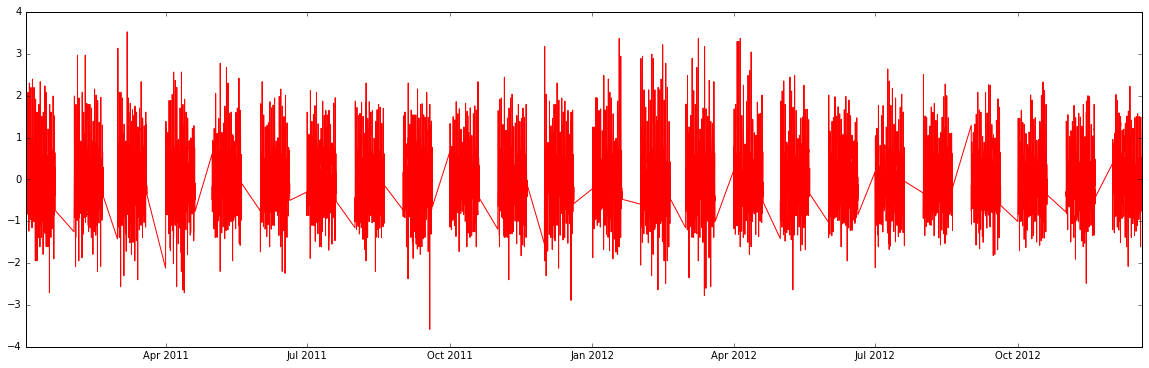

In [104]:
print("** Nom des variables : \n ")
print(x_train.columns)

r_mean = pandas.rolling_mean(y,window=24*30)
r_std = pandas.rolling_var(y,window=24)
plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(x_train["datetime"], y,'r')
plt.plot(x_train["datetime"],r_mean,'b')
plt.plot(x_train["datetime"],r_std,'y')

print('Sttionarity check')
plt.plot(x_train["datetime"], np.log(y).diff(),'r')

print("\n ** Stats descriptives sur les variables numériques : \n ")
print(x_train.describe())

print("\n")
print("** Nombre de valeurs manquantes dans les données de training : \n ")
print(x_train.isnull().sum(axis=0))

In [116]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

ts_log_diff = np.diff(np.log(y))

lag_acf = acf(ts_log_diff, nlags=10)
lag_pacf = pacf(ts_log_diff, nlags=10, method='ols')



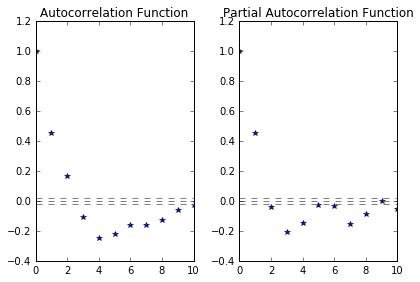

In [174]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf,'*')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf,'*')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [131]:
a = pandas.concat([x_train["datetime"],y],axis=1)
a.index = x_train["datetime"]

In [178]:
from statsmodels.tsa.arima_model import ARIMA

ts_log = np.log(a["count"])
model = ARIMA(ts_log, order=(3, 1, 2))  
results_ARIMA = model.fit()  

c:\users\wymeka\documents\python\python\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


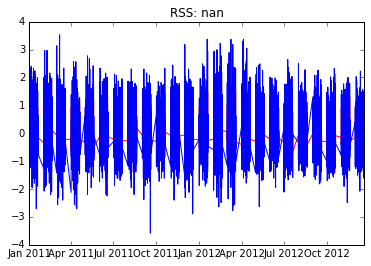

In [176]:
ts_log_diff = np.log(a["count"]).diff()
ts_log_diff[0] = 0
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.plot(ts_log_diff, color='blue')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

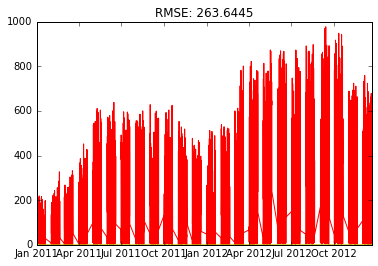

In [179]:
predictions_ARIMA_diff = pandas.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

predictions_ARIMA_log = pandas.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(a["count"],'r')
plt.plot(predictions_ARIMA,'y')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-a["count"])**2)/len(a["count"])))

## Eclatement des variables catégorielles en plusieus variables dichotomiques

In [163]:
predictions_ARIMA

datetime
2011-01-01 00:00:00    16.000000
2011-01-01 01:00:00    16.002153
2011-01-01 02:00:00    24.179205
2011-01-01 03:00:00    20.816389
2011-01-01 04:00:00    10.952787
2011-01-01 05:00:00     3.092947
2011-01-01 06:00:00     2.847342
2011-01-01 07:00:00     5.810445
2011-01-01 08:00:00     9.502691
2011-01-01 09:00:00    15.006764
2011-01-01 10:00:00    19.123526
2011-01-01 11:00:00    23.794022
2011-01-01 12:00:00    23.180973
2011-01-01 13:00:00    19.251584
2011-01-01 14:00:00    13.934823
2011-01-01 15:00:00     9.820458
2011-01-01 16:00:00     6.851113
2011-01-01 17:00:00     4.485999
2011-01-01 18:00:00     2.826744
2011-01-01 19:00:00     1.694777
2011-01-01 20:00:00     1.392888
2011-01-01 21:00:00     1.274263
2011-01-01 22:00:00     1.117925
2011-01-01 23:00:00     0.930772
2011-01-02 00:00:00     0.937164
2011-01-02 01:00:00     0.678329
2011-01-02 02:00:00     0.599797
2011-01-02 03:00:00     0.519057
2011-01-02 04:00:00     0.483024
2011-01-02 06:00:00     0.459753
 

In [14]:
def dim_feature(x, feature_name):
    dv =DictVectorizer()
    z=dv.fit_transform(pandas.DataFrame(x[feature_name].apply(str)).to_dict(orient='records'))
    feature_dimmed = pandas.DataFrame(z.toarray(),columns=dv.get_feature_names())
    feature_dimmed = feature_dimmed.drop(feature_dimmed.columns[-1],axis=1)
    return feature_dimmed

In [15]:
seasons_dimmed = dim_feature(x_train, 'season')
weather_dimmed = dim_feature(x_train, 'weather')
hour_dimmed = dim_feature(x_train, 'hour')
#day_dimmed = dim_feature(x_train, 'day')
month_dimmed =dim_feature(x_train, 'month')
#year_dimmed =dim_feature(x_train,'year')

seasons_dimmed_test = dim_feature(x_test, 'season')
weather_dimmed_test = dim_feature(x_test, 'weather')
hour_dimmed_test = dim_feature(x_test, 'hour')
#day_dimmed_test = dim_feature(x_test, 'day')
month_dimmed_test =dim_feature(x_test, 'month')
#year_dimmed_test =dim_feature(x_test,'year')

In [30]:
x_train_final = pandas.concat([x_train,seasons_dimmed,weather_dimmed,hour_dimmed,month_dimmed],axis=1)

x_train_final = x_train_final.drop('weather',axis=1)
x_train_final = x_train_final.drop('season',axis=1)

In [31]:
x_test_final = pandas.concat([x_test,seasons_dimmed_test,weather_dimmed_test,hour_dimmed_test,month_dimmed_test],axis=1)

x_test_final = x_test_final.drop('weather',axis=1)
x_test_final = x_test_final.drop('season',axis=1)

In [32]:
x_train_final.columns

Index(['datetime', 'holiday', 'workingday', 'temp', 'atemp', 'humidity',
       'windspeed', 'hour', 'day', 'month', 'year', 'season=1', 'season=2',
       'season=3', 'weather=1', 'weather=2', 'weather=3', 'hour=0', 'hour=1',
       'hour=10', 'hour=11', 'hour=12', 'hour=13', 'hour=14', 'hour=15',
       'hour=16', 'hour=17', 'hour=18', 'hour=19', 'hour=2', 'hour=20',
       'hour=21', 'hour=22', 'hour=23', 'hour=3', 'hour=4', 'hour=5', 'hour=6',
       'hour=7', 'hour=8', 'month=1', 'month=10', 'month=11', 'month=12',
       'month=2', 'month=3', 'month=4', 'month=5', 'month=6', 'month=7',
       'month=8'],
      dtype='object')

In [33]:
x_train_no_date = x_train_final.drop(["datetime","year","hour","day","month"], axis=1)

In [34]:
x_test_no_date = x_test_final.drop(["year","hour","day","month"], axis=1)

In [65]:
x_test_no_date.dtypes

datetime      datetime64[ns]
holiday                int64
workingday             int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
season=1             float64
season=2             float64
season=3             float64
weather=1            float64
weather=2            float64
weather=3            float64
hour=0               float64
hour=1               float64
hour=10              float64
hour=11              float64
hour=12              float64
hour=13              float64
hour=14              float64
hour=15              float64
hour=16              float64
hour=17              float64
hour=18              float64
hour=19              float64
hour=2               float64
hour=20              float64
hour=21              float64
hour=22              float64
hour=23              float64
hour=3               float64
hour=4               float64
hour=5               float64
hour=6               float64
hour=7        

## Setting up the model 

In [36]:
X_train, X_test, count_train, count_test = train_test_split(x_train_no_date, y, test_size=0.33, random_state=1234)

In [37]:
X_train_re, X_test_re, registered_train, registered_test = train_test_split(x_train_no_date, registered, test_size=0.33, random_state=1234)

In [38]:
X_train_ca, X_test_ca, casual_train, casual_test = train_test_split(x_train_no_date, casual, test_size=0.33, random_state=1234)

Mean squared error of log($\hat{y} +1 $) and log(y + 1)

In [39]:
def compute_kaggle_score(y_hat,y):
    return mean_squared_error(pandas.Series(np.log(y_hat+1)),np.log(y+1))

### 1) Estimating count directly

In [93]:
reg = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5, fit_intercept=True,normalize=True, scoring = mean_squared_error)
reg.fit(X_train,count_train)       

RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5, fit_intercept=True, gcv_mode=None,
    normalize=True,
    scoring=<function mean_squared_error at 0x0000000009A41510>,
    store_cv_values=False)

In [41]:
y_hat_train = reg.predict(X_train)
y_hat_test = reg.predict(X_test)

# Training error
print(compute_kaggle_score(abs(y_hat_train),count_train))

# Test error
print(compute_kaggle_score(abs(y_hat_test),count_test))

0.956243521662
0.989032197844


In [45]:
from sklearn.ensemble import GradientBoostingRegressor
est = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1,max_depth=2, random_state=0, loss='ls')

In [46]:
est.fit(X_train,count_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=2, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=0, subsample=1.0, verbose=0,
             warm_start=False)

In [59]:
y_hat_train = est.predict(X_train)
y_hat_test = est.predict(X_test)

# Training error
print(compute_kaggle_score(abs(y_hat_train),count_train))

# Test error
print(compute_kaggle_score(abs(y_hat_test),count_test))

0.47456306267
0.523509955116


In [66]:
y_test = est.predict(x_test_no_date.drop('datetime',axis=1))

In [68]:
y_hat_test = pandas.concat([x_test_no_date["datetime"],pandas.DataFrame(abs(y_test))],axis=1)
y_hat_test.to_csv('results.csv',index=False)

In [72]:
from sklearn.cross_validation import cross_val_predict

y_hat_train = cross_val_predict(est, x_train_no_date, y, cv=5)

In [76]:
print(compute_kaggle_score(abs(y_hat_train),y))

0.844499659195


### 2) Estimating registered and casual one by one , and sum 

In [89]:
reg = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5, fit_intercept=True,normalize=True, scoring = mean_squared_error)
reg.fit(X_train_re,registered_train)   

RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5, fit_intercept=True, gcv_mode=None,
    normalize=True,
    scoring=<function mean_squared_error at 0x00000000097892F0>,
    store_cv_values=False)

In [46]:
re_hat_train = reg.predict(X_train)
re_hat_test = reg.predict(X_test)

# Training error
print(mean_squared_error(re_hat_train,registered_train))

# Test error
print(mean_squared_error(re_hat_test,registered_test))

9503.9540852
9589.18491322


In [47]:
reg = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5, fit_intercept=True,normalize=True, scoring = mean_squared_error)
reg.fit(X_train_ca,casual_train)   

RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5, fit_intercept=True, gcv_mode=None,
    normalize=True,
    scoring=<function mean_squared_error at 0x00000000097892F0>,
    store_cv_values=False)

In [48]:
ca_hat_train = reg.predict(X_train)
ca_hat_test = reg.predict(X_test)

# Training error
print(mean_squared_error(ca_hat_train,casual_train))

# Test error
print(mean_squared_error(ca_hat_test,casual_test))

1040.96482729
1025.62780726


Sum of casual and registered

In [61]:
# Training error
print(mean_squared_error(ca_hat_train + re_hat_train,count_train)/max((ca_hat_train+re_hat_train - count_train))

# Test error
print(mean_squared_error(ca_hat_test + re_hat_test,count_test))

40.623940704
12967.033654


In [137]:
reg.score(X_train,abs(count_train))

0.65530951512236424

In [112]:
reg.score(X_test,count_test)

0.63440006552013695

In [147]:
y_hat_test = reg.predict(x_test_no_date.drop("datetime",axis=1))

In [50]:
y_hat_test = pandas.concat([x_test_no_date["datetime"],pandas.DataFrame(y_hat_test)],axis=1)

In [51]:
pandas.Series(y_hat_test).to_csv('results.csv',index=False)

TypeError: 'int' object is not iterable

In [88]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, criterion='mse', max_depth=5)

In [89]:
rf.fit(X_train,count_train)
y_hat_train = rf.predict(X_train)
y_hat_test = rf.predict(X_test)

# Training error
print(compute_kaggle_score(abs(y_hat_train),count_train))

# Test error
print(compute_kaggle_score(abs(y_hat_test),count_test))

1.69362463495
1.74446551671


In [90]:
y_hat_train = cross_val_predict(rf, x_train_no_date, y, cv=5)

In [92]:
print(compute_kaggle_score(abs(y_hat_train),y))

1.88881112072
